## **Modelo de Predicción de Tiempo de Espera De Los Asegurados en Accidentes de Tránsito**

**Comprensión del Negocio**

En el sector asegurador, brindar una atención rápida y eficiente a los asegurados durante una incidencia vial, es un factor clave para garantizar la satisfacción y optimizar el uso de los recursos operativos.

Actualmente, las aseguradoras enfrentan importantes desafíos en la asignación efectiva de gestores y unidades móviles. Las decisiones sobre el desplazamiento al lugar del siniestro suelen basarse en criterios generales o en la experiencia previa, lo que puede generar tiempos de espera prolongados, asignaciones ineficientes y, en consecuencia, una experiencia insatisfactoria para el asegurado.

**Objetivo del Proyecto**

Predecir el tiempo de espera en la atención de un asegurado durante una incidencia o accidente de tránsito desarrollando un modelo de Machine Learning con el fin de facilitar la asignación adecuada del gestor de seguros.

**Objetivos Específicos**

1.	Recolectar y preprocesar datos históricos relevantes sobre incidentes de tránsito, incluyendo variables como tipo de accidente, ubicación, hora del evento, tiempo de respuesta, criticidad del caso y perfil del asegurado.
2.	Delimitar la ubicación donde se va implementar, sería área metropolitana, convertirla en objetivo
3.	Identificar y seleccionar las variables más significativas que influyen en el tiempo de espera, mediante técnicas de análisis exploratorio de datos (EDA) y selección de características.
4.	Diseñar y entrenar modelos de Machine Learning supervisados, comparando distintos algoritmos (como regresión lineal, árboles de decisión, random forest o XGBoost), para predecir el tiempo de espera en función de las condiciones del accidente.
5.	Evaluar el rendimiento de los modelos generados, con la metodología de evaluación de Cross Validation, utilizando métricas como MAE (Mean Absolute Error), RMSE (Root Mean Squared Error) y R², con el fin de seleccionar el modelo más preciso y eficiente.
6.	Implementar un sistema de recomendación basado en el modelo predictivo, que sugiera la asignación óptima del gestor de seguros y determine si se requiere o no desplazamiento al lugar del incidente.


## **1. Librerias y configuraciones previas**

In [158]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib

# Gestion de librerias
# ==============================================================================
from importlib import reload

# Preprocesado y modelado
# ==============================================================================

#creación de modelos
from sklearn.ensemble import GradientBoostingRegressor

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#import statsmodels.api as sm
import math

#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## **2. Funciones**

In [159]:
# Función para graficar atributos en barras, pair plot o box-plot
def multiple_plot(ncols, data, columns, target_var, plot_type, title, rot):
    '''
    Returns the figure build from input parameters.

        Parameters:
            ncols       [integer]    Number of columns for subplots.
            data        [dataframe]  Features dataframe.
            columns     [list]       List of names of featutes in dataframe to plot.
            target_var  [string]     Name of column of target variable or feature.
            plot_type   [string]     Name of graphic. [countplot, boxplt or scatterplot]
            title       [string]     Title for figure
            rot         [integer]    Rotation angle for x axis labels
        Returns:
            Plot of figure

    Ejemplos:
        multiple_plot(1, d , None, 'bad_credit', 'countplot', 'Frecuencia de instancias para la variable bad_credit',0)
        multiple_plot(1, d , 'purpose', 'age_yrs', 'boxplot', 'Distribución de la variable próposito vs la edad',90)
        multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)
        multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)
        multiple_plot(3, d , catCols, 'age_yrs', 'boxplot', 'Distribución de la variables categóticas vs. la edad',30)
    '''


    # Paletas de colores y colores de las gráficas
    paletas = ['nipy_spectral','hsv','jet_r','Paired','Set2','Dark2','tab10','husl','mako']
    color = ['steelblue','forestgreen', 'amber']


    # Parámetros iniciales
    title_dist = 1.1  # Ajusta la distancia vertical del título en el gráfico
    x = -1            # Ubicación en el eje x del gráfico
    y =  0            # Ubicación en el eje y del gráfico
    nrows = 1         # Número inicial de filas


    # Ajustar el número de filas según el tipo de gráfico y la cantidad de columnas
    if isinstance(columns, list):
        nrows = math.ceil(len(columns) / ncols)

    # Crear el gráfico según el tipo especificado
    if ((nrows <= 1 and ncols <= 1) or plot_type == 'scatterplot'):

        # Countplot
        if plot_type == 'countplot':
            # Configurar el gráfico countplot
            fig, axes = plt.subplots(1, 1, figsize=(6, 4))
            ax_cond = axes
            sns.countplot(data=data,
                          x=target_var,
                          ax=axes,
                          palette=paletas[0],
                          zorder=1,
                          order=data[target_var].value_counts().index,
                          alpha=0.8
                          )
            # Personalizar el eje x
            ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)
            # Configurar título
            ax_cond.set_title(title, fontsize=14, fontweight="bold", y=title_dist)

        # Boxplot
        elif plot_type == 'boxplot':
            # Configurar el gráfico boxplot
            fig, axes = plt.subplots(1, 1, figsize=(6, 4))
            ax_cond = axes
            sns.boxplot(data=data,
                        x=columns,
                        y=target_var,
                        ax=axes,
                        palette=paletas[0],
                        zorder=1
                        )
            # Personalizar el eje x
            ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)
            # Configurar título
            ax_cond.set_title(title, fontsize=14, fontweight="bold", y=title_dist)


        # Scatterplot Matrix (Pairplot)
        elif plot_type == 'scatterplot':
            # Configurar el gráfico pairplot
            plot = sns.pairplot(data[columns],
                                palette=paletas[0],
                                diag_kws={'color': color[1]},
                                plot_kws={'color': color[0]},
                                diag_kind='kde'
                                )
            # Ajustar el tamaño del gráfico
            plot.fig.set_size_inches(12, 12)
            # Añadir un título al pairplot
            plot.fig.suptitle(title, fontsize=14, fontweight="bold")
            # Ajustar el diseño para evitar solapamientos
            plt.subplots_adjust(top=0.9)
            # Mostrar el gráfico
            plt.show()

    # Graficar más de un subplot
    else:
        # Crear subplots con el número especificado de filas y columnas
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, (nrows * 3) + 1))

        for i, column in enumerate(columns):
            x = x + 1

            # Reiniciar x e incrementar y si x alcanza el número de columnas
            if x >= ncols:
                y = y + 1
                x = 0

            # Configurar el subplot actual
            if nrows == 1:
                ax_cond = axes[i]
                title_dist = 1.1
            else:
                ax_cond = axes[y, x]

            # Crear el gráfico según el tipo especificado
            if plot_type == 'countplot':
                # Countplot
                sns.countplot(data=data,
                              x=column,
                              ax=ax_cond,
                              palette=paletas[0],
                              zorder=1,
                              edgecolor='black',
                              linewidth=0.5,
                              order=data[column].value_counts().index
                              )

            elif plot_type == 'boxplot':
                # Boxplot
                sns.boxplot(data=data,
                            x=column,
                            y=target_var,
                            ax=ax_cond,
                            palette=paletas[0],
                            zorder=1
                            )

            # Añadir cuadrícula en el eje y
            ax_cond.grid(axis='y', zorder=0)
            # Personalizar el eje x
            ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)
            # Configurar título del subplot
            ax_cond.set_title(column, fontsize=10)
            # Ajustar tamaño de las etiquetas
            ax_cond.tick_params(labelsize=8)
            # Limpiar etiquetas del eje x
            ax_cond.set_xlabel("")

        # Ajustar el diseño y el título general del conjunto de subplots
        fig.tight_layout()
        fig.suptitle(title, fontsize=14, fontweight="bold", y=title_dist - 0.15)
        plt.subplots_adjust(top=0.9)

        # Eliminar subplots sin datos si hay más de una fila
        if nrows > 1:
            for ax in axes.flat:
                if not bool(ax.has_data()):
                    fig.delaxes(ax)  # Eliminar si no hay datos en el subplot

## **Comprensión de los Datos**

se realizó un análisis exploratorio sobre el conjunto de datos proporcionado por la empresa AsisNet, que contiene información detallada de accidentes de tránsito atendidos por la empresa, a partir del **mes de abril del 2016 al 11 de mayo del 2025**.

El DataSet tiene el nombre **DataSet_Aseguradora.xlsx** y se encuentra en formato de excel con extensión .xlsx , con un tamaño de **3.330 Kb** el cual contiene **14520** registros y **28** variables , la información del dataset fue obtenida mediante una consulta Transat SQL en un servidor de base de datos SQL Server, que contiene información de las incidencias de tránsito y de las gestiones de atención realizadas por los agentes de las aseguradoras suscritas a la empresa AsisNet .


**A continuación una breve descripción de las variables:**

****

| Columna           | Descripción                                                                 | Ejemplo                     |
|-------------------|------------------------------------------------------------------------------|-----------------------------|
| idproceso         | Código para identificar el caso                                              | 10                          |
| placa             | Placa del vehículo                                                           | BQX320                      |
| fecha             | Fecha en que se reporta el accidente                                         | 2025-05-02 10:40:25         |
| fechallegada      | Fecha en que se llega al sitio donde ocurrió el accidente                   | 2025-05-02 10:50:25         |
| annoregistro      | Año en que se reporta el accidente                                           | 2025                        |
| mesregistro       | Mes en que se reporta el accidente                                           | 5                           |
| diaregistro       | Día en que se reporta el accidente                                           | 2                           |
| horaregistro      | Hora en que se reporta el accidente                                          | 10                          |
| diasemana         | Día de la semana en que se reporta el accidente                              | Lunes                       |
| annoatencion      | Año en que se llega al sitio donde ocurrió el accidente                     | 2025                        |
| mesatencion       | Mes en que se llega al sitio donde ocurrió el accidente                     | 5                           |
| diaatencion       | Día en que se llega al sitio donde ocurrió el accidente                     | 2                           |
| Horaantencion     | Hora en que se llega al sitio donde ocurrió el accidente                    | 10                          |
| TiempoAtencion    | Diferencia en minutos entre el reporte y la llegada                         |                             |
| HoraPicoTarde     | ¿Ocurrió en hora pico de la tarde (5 a 7 pm)? (Sí/No)                       | Si                          |
| HoraPicoManana    | ¿Ocurrió en hora pico de la mañana (6:30 a 8:30 am)? (Sí/No)                | No                          |
| InicioNoche       | ¿Ocurrió entre las 7 pm y 11:59 pm? (Sí/No)                                 | No                          |
| Amanecer          | ¿Ocurrió entre las 12 am y 5:59 am? (Sí/No)                                 | Si                          |
| Municipio         | Municipio donde ocurrió el accidente                                         | No                          |
| Intsancia         | Tipo de accidente reportado por la aseguradora                              | Preliminar con lesiones     |
| clienteimportante | Si el asegurado es cliente importante                                       | Banco de accidente          |
| Acuerdo           | Al acuerdo que se llega entre las partes implicadas                         | Tránsito                    |
| UsuarioRegistra   | Usuario que registra el caso en el sistema                                   | Carolina Garcia Valencia    |
| LiberaVehiculo    | Si el vehículo fue retenido y luego liberado                                | Liberado                    |
| ResultadoFallo    | Si el fallo en audiencias es a favor o en contra                            | A favor                     |
| Aseguradora       | Aseguradora que reporta el accidente                                        | Liberty Seguros             |
| Abogadounico      | Abogado disponible para atender el caso                                     | Carolina Garcia Valencia    |
| RandomAbogado     | Abogado que finalmente atiende el caso                                      | Carolina Garcia Valencia    |


## **3. Carga del dataset**

In [160]:
# Cargar el archivo Excel
archivo = "/content/DataSet_PREDITIMESACC.xlsx"
df = pd.read_excel(archivo)

# Ver estructura básica
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head(3))

# Configuración estética
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))


Dimensiones del dataset: (14519, 28)

Primeras filas:


,idproceso,placa,fecha,fechallegada,annoregistro,mesregistro,diaregistro,horaregistro,diasemana,annoatencion,...,Municipio,Instancia,clienteimportante,Acuerdo,UsuarioRegistra,LiberaVehiculo,ResultadoFallo,Aseguradora,Abogadounico,RandomAbogado
0,8812,USV110,2016-10-14 13:42:32.397,NaN,2016,10,14,13,Viernes,NaN,...,Abejorral,AUDIENCIA,NaN,NaN,Elkin Lezcano,NaN,NaN,Liberty Seguros SA,Andi Asistencia SA,Juan Felipe Hoyos Botero
1,10995,KAO616,2016-11-28 16:59:55.587,2016-11-28 17:00:22.177,2016,11,28,16,Lunes,2016.0,...,Abejorral,SIMPLE,NaN,NaN,JOHAN ALEXANDER MESA RIVERA,NaN,NaN,Liberty Seguros SA,Luis Fernando Saldarriaga Rodriguez,Elkin Lezcano
2,10998,HNZ243,2016-11-29 10:47:56.770,2016-11-29 11:37:14.017,2016,11,29,10,Martes,2016.0,...,Abejorral,TELEFÓNICA,NaN,NaN,Elkin Lezcano,NaN,NaN,Liberty Seguros SA,Andi Asistencia SA,Luis Fernando Saldarriaga Rodriguez


<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

**La mayoría de nuestros datos son tipo Object , tenemos fechas no convertidas, lo que puede requerir conversión para el análisis**

In [161]:
df.info() #Visualización de las columnas e identificación de los tipos de columnas que tiene el DataSet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14519 entries, 0 to 14518
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idproceso          14519 non-null  int64  
 1   placa              14519 non-null  object 
 2   fecha              14519 non-null  object 
 3   fechallegada       12955 non-null  object 
 4   annoregistro       14519 non-null  int64  
 5   mesregistro        14519 non-null  int64  
 6   diaregistro        14519 non-null  int64  
 7   horaregistro       14519 non-null  int64  
 8   diasemana          14519 non-null  object 
 9   annoatencion       12955 non-null  float64
 10  mesatencion        12955 non-null  float64
 11  diaatencion        12955 non-null  float64
 12  Horaantencion      12955 non-null  float64
 13  TiempoAtencion     12955 non-null  float64
 14  HoraPicoTarde      14519 non-null  object 
 15  HoraPicoManana     14519 non-null  object 
 16  InicioNoche        145

**Interpretación de los valores nulos :**

| Columna                                         | % de valores nulos | Interpretación                                                                 |
|-------------------------------------------------|---------------------|--------------------------------------------------------------------------------|
| ResultadoFallo                                  | ~99%                | Esta columna está casi vacía → podría eliminarse si no es esencial.           |
| LiberaVehiculo                                  | ~99%                | Lo mismo: casi sin datos útiles.                                              |
| clienteimportante                               | ~97%                | Muy pocos clientes están marcados como "importantes" → quizás conviene convertirla en binaria o eliminarla. |
| Acuerdo                                         | ~60%                | Más de la mitad vacía, revisar si los valores presentes aportan información clave. |
| diaatencion                                     | ~10%                | Valores ausentes para ciertos registros, posiblemente porque no se brindó atención. |
| mesatencion                                     | ~10%                | Valores ausentes para ciertos registros, posiblemente porque no se brindó atención. |
| annoatencion                                    | ~10%                | Valores ausentes para ciertos registros, posiblemente porque no se brindó atención. |
| fechallegada                                    | ~10%                | Coinciden con lo anterior, su ausencia puede estar relacionada con procesos no atendidos. |
| Horaatencion                                    | ~10%                | Coinciden con lo anterior, su ausencia puede estar relacionada con procesos no atendidos. |
| TiempoAtencion                                  | ~10%                | Coinciden con lo anterior, su ausencia puede estar relacionada con procesos no atendidos. |
| Abogadounico                                    | ~7-8%               | Algunos procesos no tienen abogado asignado.                                   |
| Aseguradora                                     | ~1%                 | Datos casi completos, los pocos nulos podrían imputarse.                       |


In [162]:
# Porcentaje de valores nulos por columna
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100
porcentaje_nulos = porcentaje_nulos[porcentaje_nulos > 0].sort_values(ascending=False)

print("Porcentaje de valores nulos por columna:")
print(porcentaje_nulos)


Porcentaje de valores nulos por columna:
ResultadoFallo       99.428335
LiberaVehiculo       98.092155
clienteimportante    96.604449
Acuerdo              59.487568
diaatencion          10.772092
mesatencion          10.772092
annoatencion         10.772092
fechallegada         10.772092
Horaantencion        10.772092
TiempoAtencion       10.772092
Abogadounico          7.741580
Aseguradora           1.102004
dtype: float64


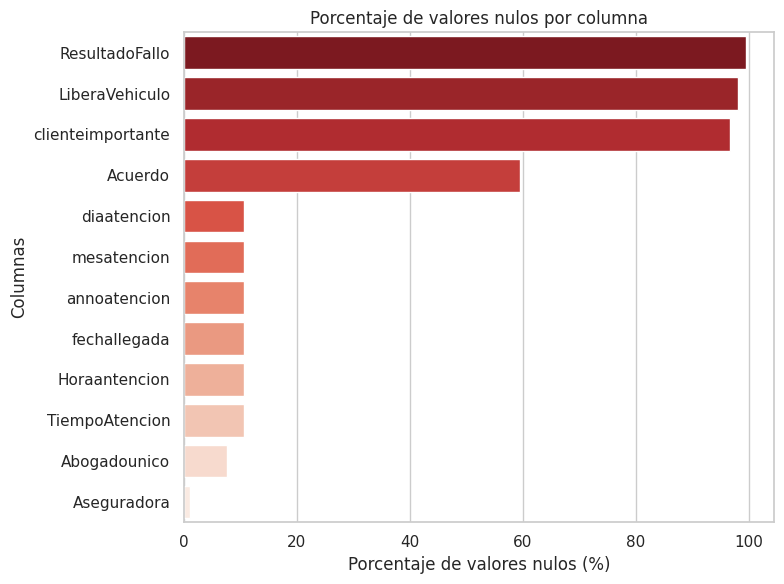

In [163]:
# Gráfico
plt.figure(figsize=(8, 6))
sns.barplot(x=porcentaje_nulos, y=porcentaje_nulos.index, palette="Reds_r")
plt.xlabel("Porcentaje de valores nulos (%)")
plt.ylabel("Columnas")
plt.title("Porcentaje de valores nulos por columna")
plt.tight_layout()
plt.show()



In [164]:
# Estadísticas descriptivas
print("Estadísticas Descriptivas:")
print(df.describe())

Estadísticas Descriptivas:
          idproceso  annoregistro   mesregistro   diaregistro  horaregistro  \
count  14519.000000  14519.000000  14519.000000  14519.000000  14519.000000   
mean   43919.231008   2020.232661      6.718782     15.929265     13.991873   
std    14705.441301      2.379397      3.517798      8.802976      4.628587   
min        7.000000   2016.000000      1.000000      1.000000      0.000000   
25%    39740.500000   2018.000000      4.000000      8.000000     11.000000   
50%    47932.000000   2021.000000      7.000000     16.000000     14.000000   
75%    54963.000000   2022.000000     10.000000     23.000000     17.500000   
max    58954.000000   2025.000000     12.000000     31.000000     23.000000   

       annoatencion  mesatencion   diaatencion  Horaantencion  TiempoAtencion  
count  12955.000000  12955.00000  12955.000000   12955.000000    1.295500e+04  
mean    2020.082748      6.69587     15.843149      14.610189    4.090372e+03  
std        2.310960  

**Análisis de las Estadísticas obtenidas:**

**Identificador y Fecha de Registro**

| Columna        | Observaciones clave                                                                                                                                |
|----------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| `idproceso`    | Identificadores únicos, van de 7 a 58,954. La dispersión (`std`) es amplia, lo que sugiere un incremento progresivo.                              |
| `annoregistro` | Registros entre 2016 y 2025. La media es 2020.2, y la mayoría están entre 2018 y 2022. Parece que hay datos de varios años, incluso futuros (2025).|
| `mesregistro`  | De 1 a 12 como se espera. Distribución balanceada (media ≈ 6.7).                                                                                    |
| `diaregistro`  | De 1 a 31. Parece bien distribuido, mediana en 16.                                                                                                  |
| `horaregistro` | De 0 a 23. Promedio ≈ 14h, lo que sugiere más registros por la tarde.                                                                               |



**Tiempo de Atencion**

| Métrica         | Valor                                                                            |
|-----------------|----------------------------------------------------------------------------------|
| **count**       | 12,955 (algunos faltantes respecto al total de 14,519 registros)                 |
| **mean**        | 4,090 segundos (~68 minutos)                                                     |
| **std**         | 40,372 → muy alta, indica gran dispersión                                        |
| **max**         | 1,793,448 segundos (~498 horas o 20 días)                                        |
| **50% (mediana)**| 28 segundos → valor central muy bajo, sugiere presencia de valores extremos     |
| **75%**         | 230 segundos (~3.8 minutos)                                                      |


**Fecha de Atención**

| Columna         | Observaciones clave                                                                                              |
|-----------------|--------------------------------------------------------------------------------------------------------------------|
| `annoatencion`  | Similar a `annoregistro`, aunque con menos datos (12,955). También va de 2016 a 2025.                             |
| `mesatencion`   | Igual que los registros. Distribución balanceada.                                                                 |
| `diaatencion`   | Mediana en 16, como el día de registro. Distribución lógica.                                                      |
| `horaatencion`  | Promedio ≈ 14.6 h. Similar a la hora de registro, pero con más dispersión.                                        |


**Estadísticas detalladas :** La mayoría de los casos (75%) son atendidos en 1 hora o menos, lo cual sugiere un proceso eficiente

| Métrica         | Valor       | Interpretación                                                                 |
|-----------------|-------------|--------------------------------------------------------------------------------|
| **count**       | 12,955      | Número de registros válidos (con ambas horas disponibles)                      |
| **mean**        | 0.59 horas  | En promedio, el vehículo es atendido ~35 minutos después de su registro        |
| **std**         | 4.25 horas  | La diferencia entre registro y atención varía bastante: hay datos dispersos    |
| **min**         | -23 horas   | Algunos registros muestran atención 23 horas antes que el registro            |
| **25% (Q1)**    | 0 horas     | El 25% de los casos fue atendido en la misma hora o antes del registro         |
| **50% (mediana)**| 0 horas    | Al menos el 50% fue atendido en la misma hora que el registro                  |
| **75% (Q3)**    | 1 hora      | El 75% fue atendido en una hora o menos después del registro                   |
| **max**         | 23 horas    | Máximo de atención casi un día después del registro                            |


**Concluimos que**: Hay outliers graves. Algunos casos pueden haber tenido errores de captura o procesos muy largos.

**Posible limpieza:** analizar casos con tiempos mayores a 1 hora (> 3600 s), y decidir si excluirlos o no.

**Recomendaciones para tratamiento de datos :**

Validar valores extremos en TiempoAtencion.

Visualizar distribuciones: histogramas por hora, día, mes, año para ver patrones.

Comparar hora de registro vs hora de atención para entender demoras

In [165]:
# Paso 1: Calcular la diferencia en horas
df_filtrado = df.dropna(subset=['horaregistro', 'Horaantencion'])
df_filtrado['DiferenciaHoras'] = df_filtrado['Horaantencion'] - df_filtrado['horaregistro']

# Paso 2: Estadísticas descriptivas
desc = df_filtrado['DiferenciaHoras'].describe()
print("Estadísticas descriptivas de la diferencia en horas:")
print(desc)

Estadísticas descriptivas de la diferencia en horas:
count    12955.000000
mean         0.594519
std          4.254787
min        -23.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         23.000000
Name: DiferenciaHoras, dtype: float64


In [166]:
# Valores únicos en algunas variables categóricas
print("\nValores únicos:")
print(df.nunique())


Valores únicos:
idproceso            14519
placa                13245
fecha                14519
fechallegada         12955
annoregistro            10
mesregistro             12
diaregistro             31
horaregistro            24
diasemana                7
annoatencion            10
mesatencion             12
diaatencion             31
Horaantencion           24
TiempoAtencion        2659
HoraPicoTarde            2
HoraPicoManana           2
InicioNoche              2
Amanecer                 2
Municipio              116
Instancia               12
clienteimportante        3
Acuerdo                 10
UsuarioRegistra          8
LiberaVehiculo           2
ResultadoFallo           4
Aseguradora             10
Abogadounico            79
RandomAbogado            8
dtype: int64


**Algunas conclusiones importantes de la identificación de los valores únicos en el DataSet**

**Identificadores y Fechas**

idproceso (14,519) → Identificador único de cada caso o proceso. Sin repeticiones.

placa (13,245) → Placa del vehículo. Hay vehículos que aparecen más de una vez.

fecha (14,519) → Fecha del evento. Totalmente única, probablemente marca un evento único por proceso.

fechallegada (12,955) → Fecha de llegada del vehículo. Algunos valores podrían repetirse o faltar.

**Variables Temporales Extra**

TiempoAtencion (2,659) → Parece ser el tiempo que tardaron en atender un caso. Mucha variación, podría ser continua o categorizable.

HoraPicoTarde, HoraPicoManana, InicioNoche, Amanecer (2 c/u) → Variables binarias (probablemente 0 o 1) que indican si el evento ocurrió en esa franja horaria.

**Ubicación**

Municipio (116) → 116 municipios diferentes. Es una variable categórica importante para análisis geográficos.

In [167]:
#Lista de variables categóricas
catCols = df.select_dtypes(include = ["object", 'category']).columns.tolist()
df[catCols].head(2)

,placa,fecha,fechallegada,diasemana,HoraPicoTarde,HoraPicoManana,InicioNoche,Amanecer,Municipio,Instancia,clienteimportante,Acuerdo,UsuarioRegistra,LiberaVehiculo,ResultadoFallo,Aseguradora,Abogadounico,RandomAbogado
0,USV110,2016-10-14 13:42:32.397,NaN,Viernes,No,No,No,No,Abejorral,AUDIENCIA,NaN,NaN,Elkin Lezcano,NaN,NaN,Liberty Seguros SA,Andi Asistencia SA,Juan Felipe Hoyos Botero
1,KAO616,2016-11-28 16:59:55.587,2016-11-28 17:00:22.177,Lunes,No,No,No,No,Abejorral,SIMPLE,NaN,NaN,JOHAN ALEXANDER MESA RIVERA,NaN,NaN,Liberty Seguros SA,Luis Fernando Saldarriaga Rodriguez,Elkin Lezcano


In [168]:
#Validando los datos categóricos podemos determinar que las siguientes columnas 'Abogadounico', 'ResultadoFallo', 'LiberaVehiculo', 'UsuarioRegistra', 'idproceso', 'placa' no aportan valor en el análisis incial de los datos
df.drop(['Abogadounico', 'ResultadoFallo', 'LiberaVehiculo', 'UsuarioRegistra', 'idproceso', 'placa'], axis='columns', inplace=True)



En el análisis de las variables categóricas se identifica que hay presencia de datos faltantes y presentan valores nulos, con lo que podemos llegar a un posible descarte en nuestro análisis fechallegada, clienteimportante,Acuerdo, LiberaVehiculo y  ResultadoFallo, se puede presentar datos faltantes debido a que se tienen datos en varias columnas tienen NaN, posibles outliers en las columnas fechallegada y Aseguradora.

Procedimos a eliminar 'Abogadounico', 'ResultadoFallo', 'LiberaVehiculo', 'UsuarioRegistra', 'idproceso', 'placa' no aportan valor en el análisis incial de los datos y convertir las variables fecha a tipo datatime

In [169]:
#Convertir datos de fecha a datetime para poder hacer un análisis más completo
df['fecha'] = pd.to_datetime(df['fecha'])
df['fechallegada'] = pd.to_datetime(df['fechallegada'])
df.info()

catCols = df.select_dtypes(include = ["object", 'category']).columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14519 entries, 0 to 14518
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha              14519 non-null  datetime64[ns]
 1   fechallegada       12955 non-null  datetime64[ns]
 2   annoregistro       14519 non-null  int64         
 3   mesregistro        14519 non-null  int64         
 4   diaregistro        14519 non-null  int64         
 5   horaregistro       14519 non-null  int64         
 6   diasemana          14519 non-null  object        
 7   annoatencion       12955 non-null  float64       
 8   mesatencion        12955 non-null  float64       
 9   diaatencion        12955 non-null  float64       
 10  Horaantencion      12955 non-null  float64       
 11  TiempoAtencion     12955 non-null  float64       
 12  HoraPicoTarde      14519 non-null  object        
 13  HoraPicoManana     14519 non-null  object        
 14  Inicio

In [170]:
#Lista de variables numéricas

numCols=df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
df[numCols].head()

,annoregistro,mesregistro,diaregistro,horaregistro,annoatencion,mesatencion,diaatencion,Horaantencion,TiempoAtencion
0,2016,10,14,13,NaN,NaN,NaN,NaN,NaN
1,2016,11,28,16,2016.0,11.0,28.0,17.0,1.0
2,2016,11,29,10,2016.0,11.0,29.0,11.0,50.0
3,2016,12,23,14,2016.0,12.0,23.0,14.0,12.0
4,2016,12,29,13,2016.0,12.0,29.0,14.0,45.0


## **4. Visualización de datos**

Análisis de todas las variables categóricas con el fin de entender su relación con los datos contenidos en el conjunto de datos.
Hacemos uso de la función **multiple_plot** definida en el Numeral 2 del NotebooK

Este análisis nos permite revisar distribuciones de variables categóricas,
Detectar clases desbalanceadas, Analizar frecuencia de aparición de valores.

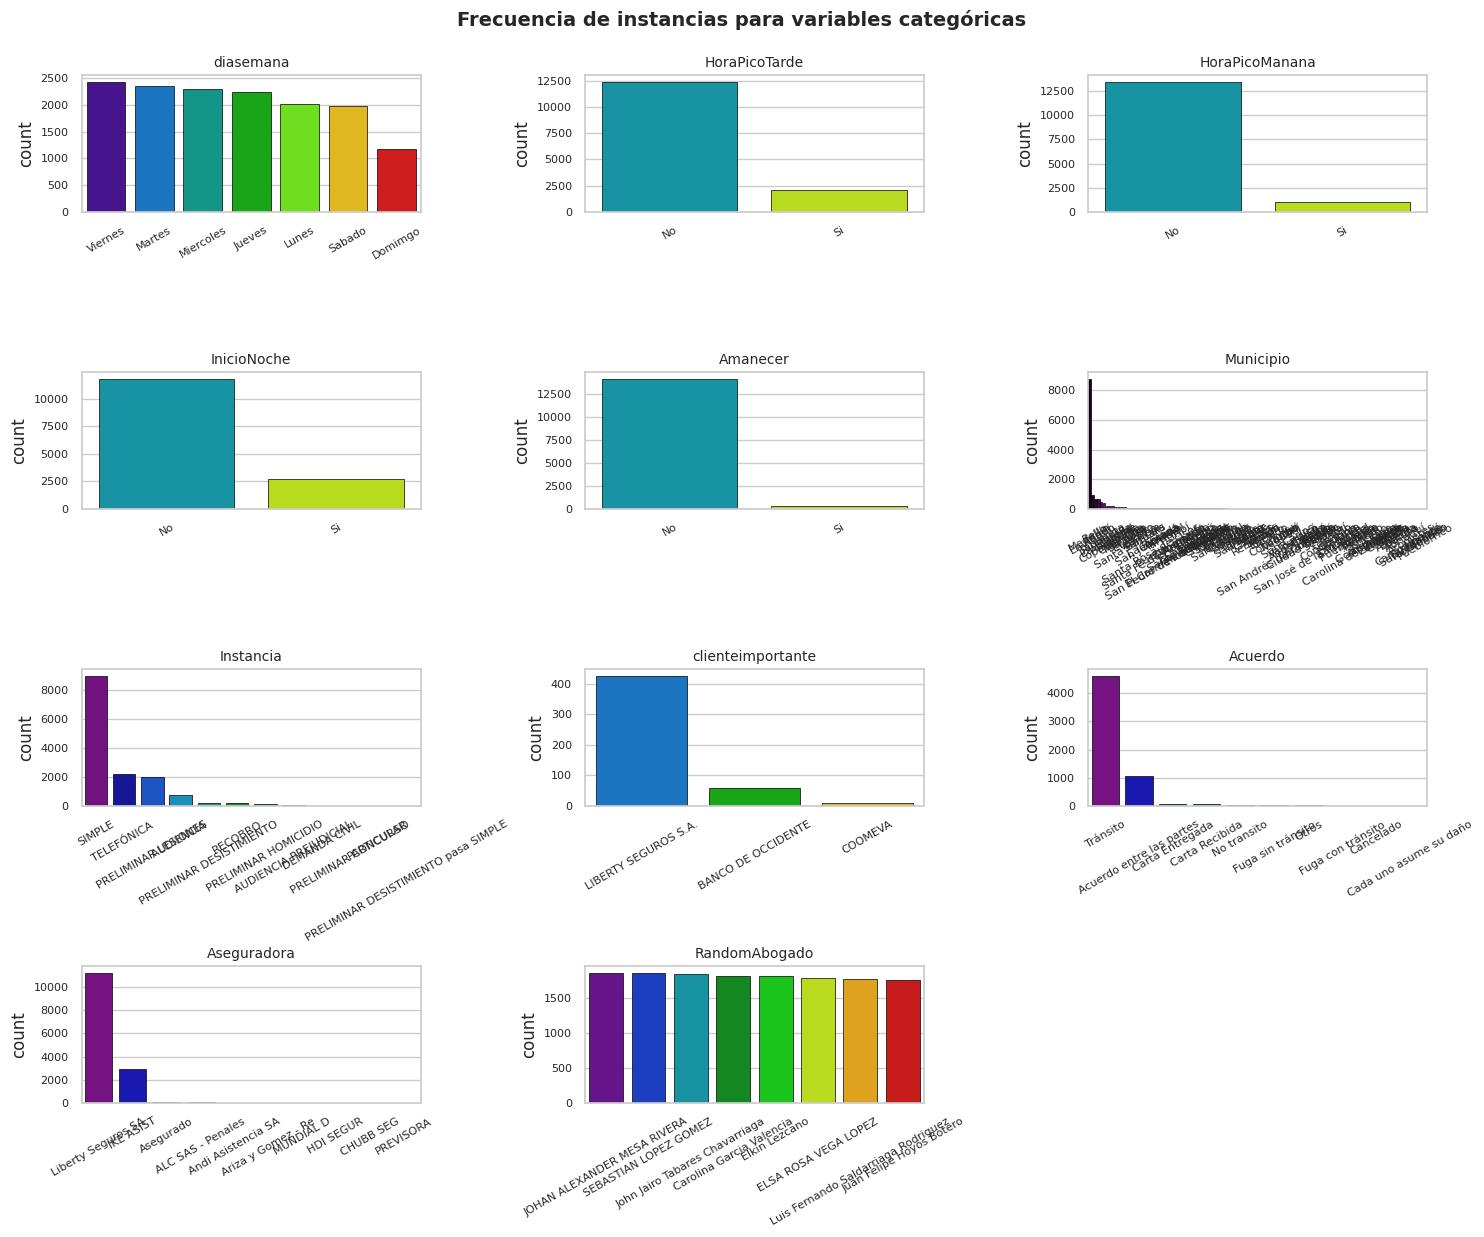

In [119]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(3, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

## **4.1 Interpretación de algunos gráficos**

Después de un análisis de frecuencia de variables categóricas podemos concluir que la información de las columnas **acuerdo, aseguradora, instancia y municipios** están un poco desbalanceada entre sus datos y es necesario hacer agrupaciones.

Debemos realizar  algunas agrupaciones de columnas para tener mejor comprensión de los datos como son:  

*   Agrupar columna **horapicomañana con horapicotarde**
*   Agrupar columna **inicionoche con amanecer**

Las columnas de **Abogadounico, LiberaVehiculo y Resultadofallo** las podemos borrar por la cantidad tan baja de datos

En la **gráfica de Distribución de Casos por Día de la Semana** identificamos que Los días martes y viernes suelen tener más incidentes de transito. Los fines de semana (sábado y domingo) tienden a mostrar menos eventos.

Esta tendencia puede relacionarse con los patrones de tráfico y movilidad urbana, posiblemente haya más flujo vehicular entre semana, especialmente al inicio y al cierre.

**Conclusión**: Se deben reforzar recursos operativos y de atención especialmente los lunes y viernes, ya que la demanda es más alta.

En la **gráfica de Las aseguradoras** se identifica que Liberty Seguros S.A y IKE ASIST concentran una cantidad significativamente mayor de incidentes reportados.

Esto puede deberse a:

Mayor cuota de mercado

Diferencias en perfiles de asegurados (edad, ubicación, tipo de vehículo).

Problemas estructurales en ciertos procesos internos.

**Conclusión**: Vale la pena hacer análisis personalizados por aseguradora para entender su comportamiento y ajustar estrategias de servicio.

In [139]:
# Distribución de cada variable categórica en el conjunto de datos
for col in catCols:
    print("="*5 + f" {col} " + "="*20)
    print(df[col].value_counts())
    print()

===== placa ====================
placa
STW598    7
KMQ482    6
WGZ952    6
TAE123    5
DLY625    5
         ..
TSF703    1
HHQ567    1
TPN363    1
OAI757    1
BIP940    1
Name: count, Length: 13245, dtype: int64

===== diasemana ====================
diasemana
Viernes      2441
Martes       2361
Miercoles    2292
Jueves       2251
Lunes        2028
Sabado       1975
Domimgo      1171
Name: count, dtype: int64

===== HoraPicoTarde ====================
HoraPicoTarde
No    12463
Si     2056
Name: count, dtype: int64

===== HoraPicoManana ====================
HoraPicoManana
No    13518
Si     1001
Name: count, dtype: int64

===== InicioNoche ====================
InicioNoche
No    11833
Si     2686
Name: count, dtype: int64

===== Amanecer ====================
Amanecer
No    14221
Si      298
Name: count, dtype: int64

===== Municipio ====================
Municipio
Medellín         8806
Envigado          903
Bello             669
Itagüí            658
Sabaneta          430
                 .

**Interpretación de la información anterior:**

La Distribución de cada variable categórica en el conjunto de datos nos permite entender como están distribuidos las varibles categóricas , encontrar valores innusuales, apoyarnos para la toma de decisiones de limpieza de datos y agrupaciones.

-Hay 13,245 placas únicas, lo que indica que casi todos los registros son de vehículos diferentes.

Algunas placas se repiten (p.ej., STW598 aparece 7 veces), lo que puede significar que ese vehículo tuvo múltiples procesos.

-La mayoría de los procesos ocurren entre semana. Viernes y martes son los días más comunes. Domingo es el menos frecuente.

-Solo un 14% de los procesos ocurrieron en la hora pico de la tarde, el resto fuera de ese horario.

-La mayoría de los casos (más del 60%) están en la instancia llamada SIMPLE.

-Casi el 80% de los casos están relacionados con una sola aseguradora, lo que podría indicar un cliente dominante.


Vamos a realizar una grafica entre instancia y Acuerdo dado que en la grafica anterior nos da la impresión que a pesar de que las instancias son simples, se ve que en los acuerdos se involucra el transito

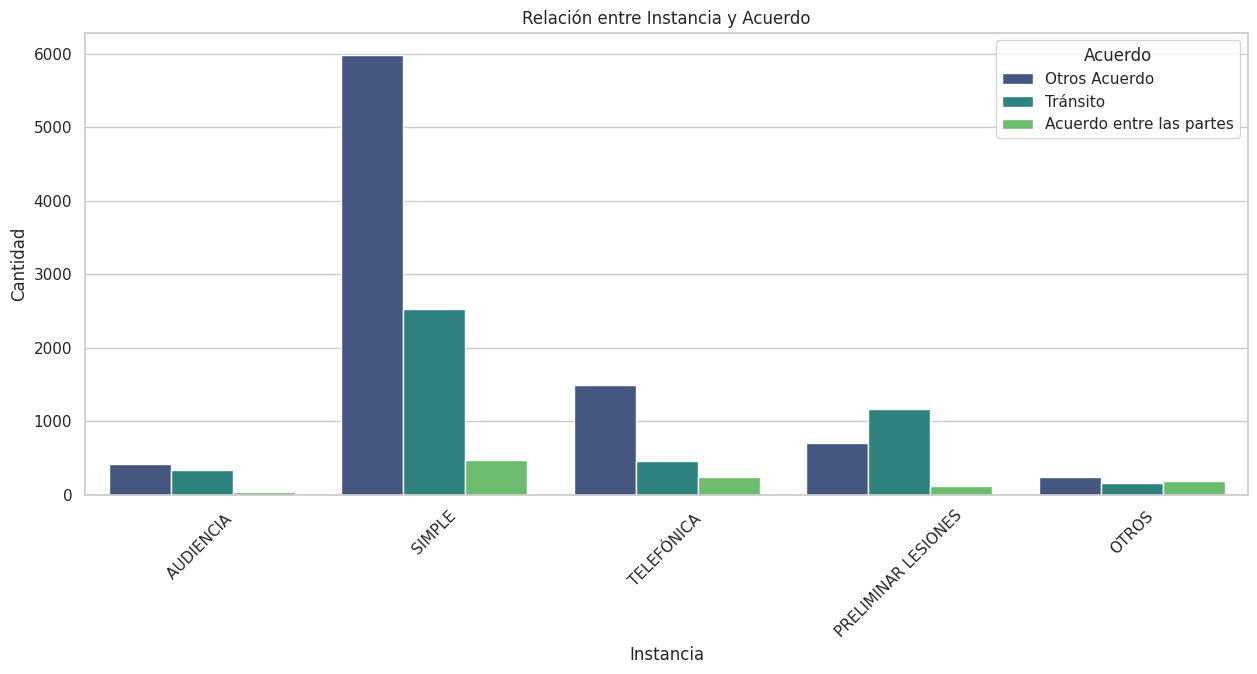

In [140]:
#Reemplazo de las instancias menos usadas praa mejorar la grafica de relacion

#Diccionario con los reemplazos a realizar
reemplazos = {  "PRELIMINAR DESISTIMIENTO": "OTROS"
              , "RECOBRO": "OTROS"
              , "PRELIMINAR HOMICIDIO": "OTROS"
              , "AUDIENCIA PREJUDICIAL": "OTROS"
              , "DEMANDA CIVIL": "OTROS"
              , "PRELIMINAR CONCURSO": "OTROS"
              , "PARTICULAR": "OTROS"
              , "PRELIMINAR DESISTIMIENTO pasa SIMPLE": "OTROS"}

#Se reemplazan los valores de acuerdo con el diccionario creado anteriormente
df_grafica = df.copy()
df_grafica['Instancia'] = df_grafica['Instancia'].map(reemplazos).fillna(df_grafica['Instancia'])

# conteo de los Acuerdos
conteo_Acuerdo = df_grafica['Acuerdo'].value_counts()
# Seleccionar los Acuerdos más comunes
top_Acuerdo = conteo_Acuerdo.nlargest(2).index

df_grafica['Acuerdo'] = df_grafica['Acuerdo'].where(
    df_grafica['Acuerdo'].isin(top_Acuerdo),
    other='Otros Acuerdo'
)

plt.figure(figsize=(15, 6))
sns.countplot(data=df_grafica, x='Instancia', hue='Acuerdo', palette='viridis')

plt.title('Relación entre Instancia y Acuerdo')
plt.xlabel('Instancia')
plt.ylabel('Cantidad')
plt.legend(title='Acuerdo')
plt.xticks(rotation=45)
plt.show()

Con la grafica podemos evidenciar que a diferencia de lo que uno pensaria que en instancias simples no se requiere transito de las 8900 de asistencias simples hay unas 2500 que se hizo finalmente la petición del transito  

**Realizamos un análisis de todas las variables númericas para entender su relación con los datos**

In [141]:
#Lista de variables numéricas
numCols=df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
df[numCols].head(2)

,idproceso,annoregistro,mesregistro,diaregistro,horaregistro,annoatencion,mesatencion,diaatencion,Horaantencion,TiempoAtencion
0,8812,2016,10,14,13,NaN,NaN,NaN,NaN,NaN
1,10995,2016,11,28,16,2016.0,11.0,28.0,17.0,1.0


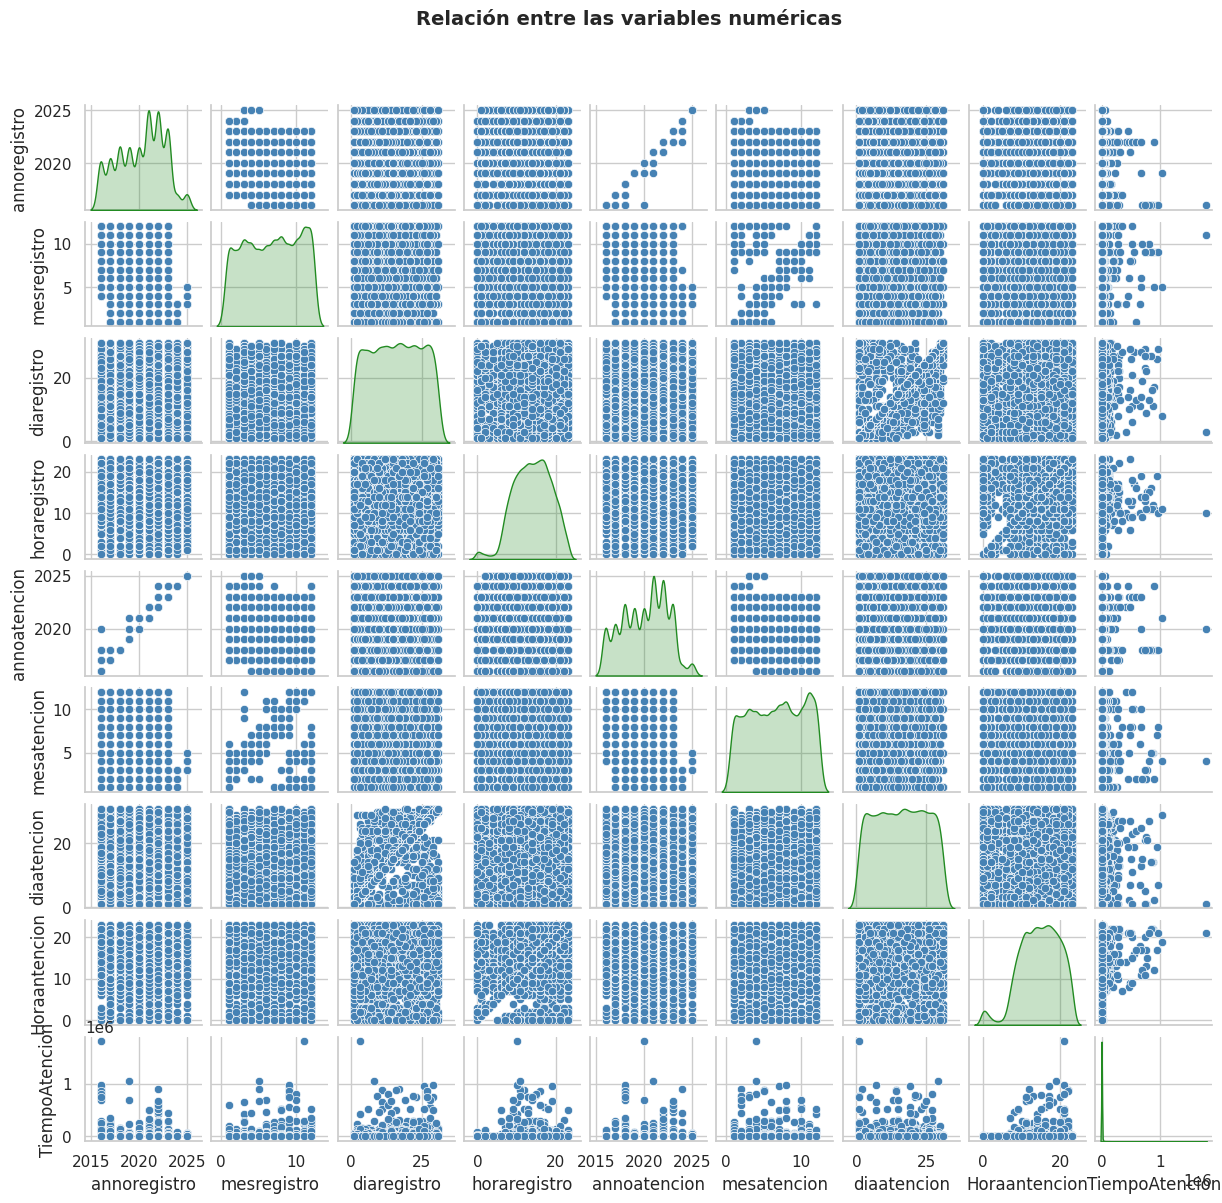

In [ ]:
#Visualización de variables numéricas
multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

En el análisis de correlación las variables numéricas podemos concluir que en la columna de **tiemposatencion** se ven algunos valores dispersos, lo que nos sugiere que se deben hacer tratamiento de valores atípicos.

**ANÁLISIS DE LAS GRÁFICAS DE CORRELACIÓN**

1. **Alta correlación entre fechas de registro y atención:**
Las variables **annoregistro** y **annoatencion**, así como mesregistro con mesatencion, y diaregistro con diaatencion, presentan patrones casi lineales.

Esto sugiere que los eventos son atendidos el mismo día o muy cerca del registro.

2. **Dispersión aleatoria en TiempoAtencion:**
Las relaciones entre **TiempoAtencion** y el resto de variables son muy dispersas (sin forma clara), especialmente con **horaregistro** y **Horaantencion**.

Indica poca o ninguna relación lineal con estas variables numéricas.

El TiempoAtencion podría estar influenciado por variables categóricas o factores externos.

3. **Distribución sesgada de TiempoAtencion:**
El gráfico de densidad de TiempoAtencion (última celda diagonal) muestra que la mayoría de los valores están agrupados en el rango bajo, pero hay valores extremadamente altos (outliers).


4. **horaregistro** y **Horaantencion** tienen un patrón similar:
Aunque no es perfecto, hay una ligera tendencia a coincidir en las horas, como ya reflejaba la correlación (~0.61).

Debemos descartar variables muy correlacionadas (multicolineales) para aplicar modelos de regresión.

Detectar y tratar outliers, especialmente en TiempoAtencion.

**Identificación de valores atípicos**



In [171]:
# Mostrar cuántos valores extremos hay (mayores a 1 hora = 3600 segundos)
outliers = df[df["TiempoAtencion"] > 3600]
print(f"Registros con TiempoAtencion > 1 hora: {len(outliers)} de {len(df)} totales")

#Análisis para identificar los valores atípicos en la columna de TiempoAtencion
Q1 = df['TiempoAtencion'].quantile(0.25)  # Primer cuartil (25%)
print(Q1)
Q3 = df['TiempoAtencion'].quantile(0.75)  # Tercer cuartil (75%)
print(Q3)
IQR = Q3 - Q1                      # Rango intercuartílico
print(IQR)

# Límites para outliers (1.5*IQR es el estándar)
limite_inferior = Q1 - 1.5 * IQR
print(limite_inferior)
limite_superior = Q3 + 1.5 * IQR
print(limite_superior)

outliers = df[(df['TiempoAtencion'] < limite_inferior) | (df['TiempoAtencion'] > limite_superior)]
print("Valores atípicos (IQR):")
print(outliers["TiempoAtencion"])

Registros con TiempoAtencion > 1 hora: 1005 de 14519 totales
8.0
230.0
222.0
-325.0
563.0
Valores atípicos (IQR):
9           933.0
11         1507.0
38         1031.0
44         2745.0
67        24463.0
           ...   
14465    133075.0
14466     96468.0
14469     99748.0
14471    106608.0
14505      3688.0
Name: TiempoAtencion, Length: 2578, dtype: float64


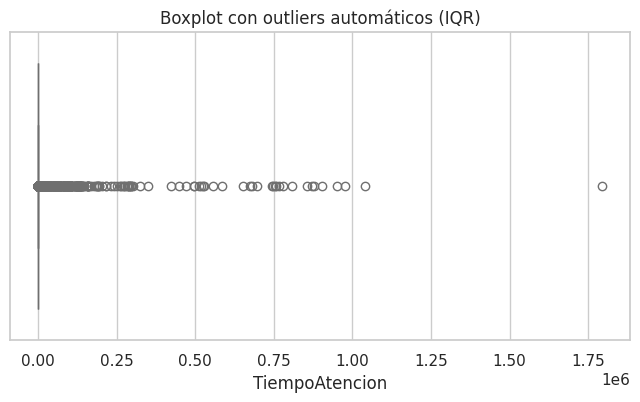

In [143]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['TiempoAtencion'], color='skyblue')
plt.title('Boxplot con outliers automáticos (IQR)')
plt.show()

Text(0, 0.5, 'Frecuencia')

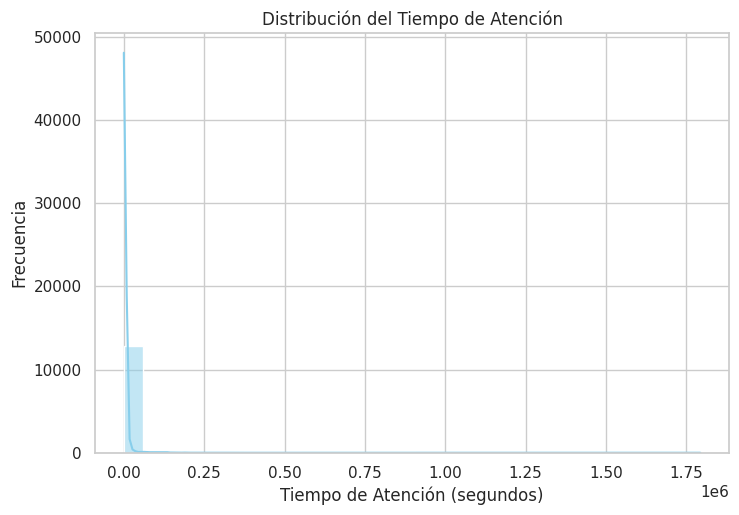

In [ ]:
#Histograma del Tiempo de Atención

# Configurar estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
sns.histplot(df['TiempoAtencion'], bins=30, kde=True, color='skyblue')
plt.title('Distribución del Tiempo de Atención')
plt.xlabel('Tiempo de Atención (segundos)')
plt.ylabel('Frecuencia')

Con la gráfica **Distribución del Tiempo de Atención** podemos concluir:

La mayoría de los incidentes se atienden en menos de 1,000 segundos (~16 minutos), lo que indica un tiempo de respuesta relativamente rápido en muchos casos.

Existe una cola hacia la derecha (**outliers**), lo cual sugiere que en ciertos eventos hay tiempos de atención excesivos.

Algunas **causas** pueden ser Ubicaciones remotas o de difícil acceso, Falta de disponibilidad de unidades móviles,Horas pico o fallos operativos.

Aunque el tiempo de atención es eficiente en general, hay que investigar los casos extremos para reducir demoras fuera de lo normal.

**Vamos hacer un análisis de todas las variables fechas para empezar a entender su relación con los datos**

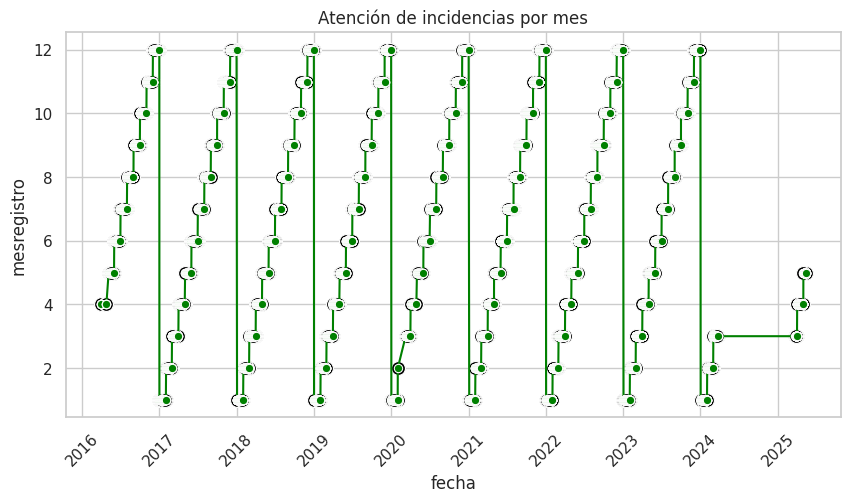

In [ ]:
#analizar valores por fechas
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='fecha', y='mesregistro', marker='o', color='green')
sns.scatterplot(data=df, x='fecha', y='mesregistro', color='black', s=100)  # Puntos destacados
plt.title('Atención de incidencias por mes')
plt.xticks(rotation=45)
plt.show()

En la gráfica **“Atención de incidencias por mes”** observamos que entre el mes de marzo del 2024 y marzo de este año no hay datos.
En validación de esta información con los abogados de la empresa AsisNet nos indican que en sus servidores se presentó durante el mes de febrero del año 2025 un ataque informático y la información de esas fechas no se logró recuperar, por lo tanto no se tiene información en este rango de tiempo.


**Análisis de todas los valores null para idenficar posibles cambios en el dataset**

In [ ]:
# Resumen de datos faltantes por columna
print("\n Valores nulos por columna:")
print(df.isnull().sum())



 Valores nulos por columna:
idproceso                0
placa                    0
fecha                    0
fechallegada          1564
annoregistro             0
mesregistro              0
diaregistro              0
horaregistro             0
diasemana                0
annoatencion          1564
mesatencion           1564
diaatencion           1564
Horaantencion         1564
TiempoAtencion        1564
HoraPicoTarde            0
HoraPicoManana           0
InicioNoche              0
Amanecer                 0
Municipio                0
Intsancia                0
clienteimportante    14026
Acuerdo               8637
UsuarioRegistra          0
LiberaVehiculo       14242
ResultadoFallo       14436
Aseguradora            160
Abogadounico          1124
RandomAbogado            0
dtype: int64


Identificamos que en el dataset presentamos gran catidadad de valores **Null**, con un mayor porcentaje en las siguientes columnas, lo cual nos lleva a un tratamiendo especial, posiblemente a una eliminación del DataSet, ya que no aportan valor a nuestro modelo:

**ResultadoFallo**

**LiberaVehiculo**

**clienteimportante**

**Acuerdo**



Esta sección debe incluir la implementación práctica en Python (utilizando Google Collaboratory) del preprocesamiento necesario. Debe presentar claramente:
● Limpieza y tratamiento de datos faltantes.
● Manejo adecuado de valores atípicos.
● Transformaciones aplicadas (normalización, estandarización, creación de variables derivadas, etc.).
● Integración de fuentes de datos si aplica.
## **Preparación de los Datos**


## **5. Limpieza y tratamiento de datos faltantes**

In [172]:
#Verificación y eliminación de registros duplicados

#Verificación de registros duplicados
df.loc[df.duplicated()]

,fecha,fechallegada,annoregistro,mesregistro,diaregistro,horaregistro,diasemana,annoatencion,mesatencion,diaatencion,...,HoraPicoTarde,HoraPicoManana,InicioNoche,Amanecer,Municipio,Instancia,clienteimportante,Acuerdo,Aseguradora,RandomAbogado


In [173]:
# eliminación de registros duplicados
df = df.drop_duplicates()

#Reiniciar el indice
df.reset_index(drop=True, inplace=True)

In [174]:
#Eliminación de categorias pequeñas para la variables categóricas relacionadas con la variable Intsancia
df['Instancia'].value_counts().sort_values(ascending=False)

,count
Instancia,
SIMPLE,8982
TELEFÓNICA,2203
PRELIMINAR LESIONES,1982
AUDIENCIA,780
PRELIMINAR DESISTIMIENTO,202
RECOBRO,172
PRELIMINAR HOMICIDIO,119
AUDIENCIA PREJUDICIAL,38
DEMANDA CIVIL,17


In [175]:
#Reemplazo de valores para la agrupación de categorías

#Diccionario con los reemplazos a realizar
reemplazos = {  "PRELIMINAR DESISTIMIENTO": "OTROS"
              , "RECOBRO": "OTROS"
              , "PRELIMINAR HOMICIDIO": "OTROS"
              , "AUDIENCIA PREJUDICIAL": "OTROS"
              , "DEMANDA CIVIL": "OTROS"
              , "PRELIMINAR CONCURSO": "OTROS"
              , "PARTICULAR": "OTROS"
              , "PRELIMINAR DESISTIMIENTO pasa SIMPLE": "OTROS"}

#Se reemplazan los valores de acuerdo con el diccionario creado anteriormente
df['Instancia'] = df['Instancia'].map(reemplazos).fillna(df['Instancia'])


#Visualización de las nuevos valores agrupados para la categoria 'Instancia'
df['Instancia'].value_counts().sort_values(ascending=False)


,count
Instancia,
SIMPLE,8982
TELEFÓNICA,2203
PRELIMINAR LESIONES,1982
AUDIENCIA,780
OTROS,572


In [148]:
#Eliminación de categorias pequeñas para la variables categoricas - Municipios
df['Municipio'].value_counts().sort_values(ascending=False).head(20)

,count
Municipio,
Medellín,8806
Envigado,903
Bello,669
Itagüí,658
Sabaneta,430
Rionegro,372
La Estrella,178
Copacabana,168
Abejorral,168


In [176]:
# conteo de los municipios
conteo_municipios = df['Municipio'].value_counts()
# Seleccionar los municipios más comunes
top_municipios = conteo_municipios.nlargest(6).index
print(f"\nLos municipios más frecuentes: {list(top_municipios)}")


Los municipios más frecuentes: ['Medellín', 'Envigado', 'Bello', 'Itagüí', 'Sabaneta', 'Rionegro']


In [177]:
df['Municipio'] = df['Municipio'].where(
    df['Municipio'].isin(top_municipios),
    other='Otros Municipios'
)

df['Municipio'].value_counts().sort_values(ascending=False).head(20)

,count
Municipio,
Medellín,8806
Otros Municipios,2681
Envigado,903
Bello,669
Itagüí,658
Sabaneta,430
Rionegro,372


In [178]:
#Eliminación de categorias pequeñas para la variableS categoricas - Aseguradora
df['Aseguradora'].value_counts().sort_values(ascending=False).head(20)

,count
Aseguradora,
Liberty Seguros SA,11225
IKE ASIST,2954
Asegurado,102
ALC SAS - Penales,36
Andi Asistencia SA,16
Ariza y Gomez - Re,11
MUNDIAL D,10
HDI SEGUR,3
CHUBB SEG,1


In [179]:
# conteo de las Aseguradoras
conteo_aseguradora = df['Aseguradora'].value_counts()
# Seleccionar las Aseguradoras más comunes
top_aseguradora = conteo_aseguradora.nlargest(2).index

df['Aseguradora'] = df['Aseguradora'].where(
    df['Aseguradora'].isin(top_aseguradora),
    other='Otras Aseguradora'
)

df['Aseguradora'].value_counts().sort_values(ascending=False).head(20)

,count
Aseguradora,
Liberty Seguros SA,11225
IKE ASIST,2954
Otras Aseguradora,340


In [180]:
#Eliminación de categorias pequeñas para la variableS categoricas - Acuerdo
df['Acuerdo'].value_counts().sort_values(ascending=False).head(20)

,count
Acuerdo,
Tránsito,4628
Acuerdo entre las partes,1052
Carta Entregada,79
Carta Recibida,49
No transito,33
Fuga sin tránsito,18
Otros,17
Fuga con tránsito,4
Cancelado,1


In [181]:
# conteo de los Acuerdos
conteo_Acuerdo = df['Acuerdo'].value_counts()
# Seleccionar los Acuerdos más comunes
top_Acuerdo = conteo_Acuerdo.nlargest(2).index

df['Acuerdo'] = df['Acuerdo'].where(
    df['Acuerdo'].isin(top_Acuerdo),
    other='Otros Acuerdo'
)

df['Acuerdo'].value_counts().sort_values(ascending=False).head(20)

,count
Acuerdo,
Otros Acuerdo,8839
Tránsito,4628
Acuerdo entre las partes,1052


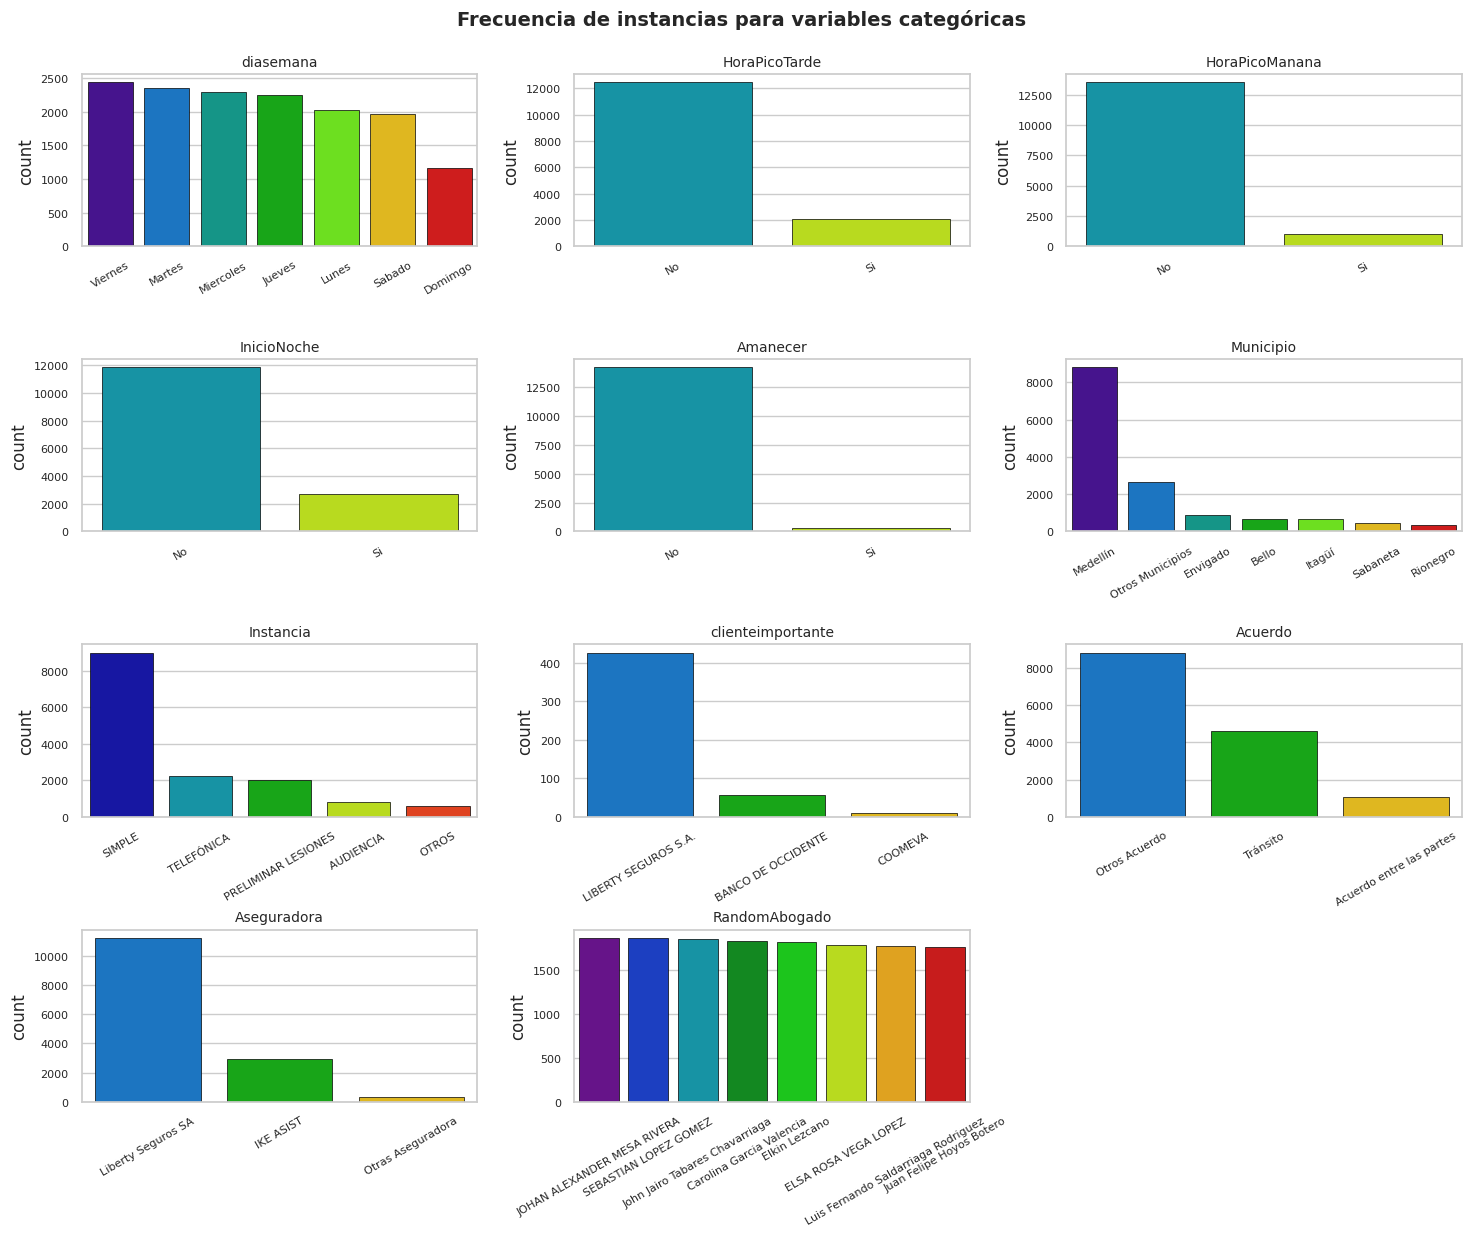

In [182]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(3, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

## **5.1 Interpretación de algunos gráficos**

En la **gráfica de Las aseguradoras** se identifica que Liberty Seguros S.A y IKE ASIST concentran una cantidad significativamente mayor de incidentes reportados.

Esto puede deberse a:

Mayor cuota de mercado

Diferencias en perfiles de asegurados (edad, ubicación, tipo de vehículo).

Problemas estructurales en ciertos procesos internos.

**Conclusión**: Vale la pena hacer análisis personalizados por aseguradora para entender su comportamiento y ajustar estrategias de servicio.

## **6. Manejo adecuado de valores atípicos.**

Vamos a realizar una gráfica de bigotes para identificar los valores atipicos y validar por que posibles valoes podemos reemplazar estos dato atipicos

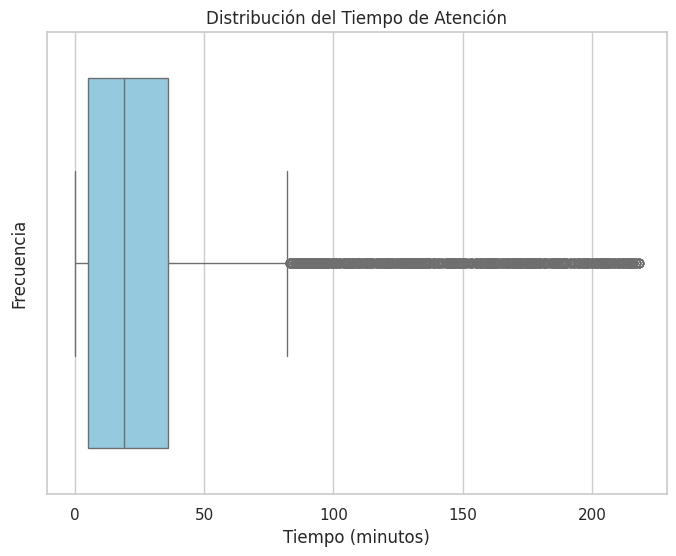

In [ ]:
# Configurar el estilo visual
sns.set(style="whitegrid")

# Crear el boxplot
plt.figure(figsize=(8, 6))  # Tamaño del gráfico
ax = sns.boxplot(x=df['TiempoAtencion'], color='skyblue')

# Personalizar ejes y título
ax.set(
    title='Distribución del Tiempo de Atención',
    xlabel='Tiempo (minutos)',
    ylabel='Frecuencia'
)

# Mostrar el gráfico
plt.show()

La gráfica nos muestra que la gan concentración de datos esta entre 0 y 50 minutos de atención, lo que nos sugiere que podemos usar la media para reemplazar los valores atipicos

In [190]:
#obtener el promedio de atención sin tener encuenta los outliers para mejor asignación
promedioatencion = df[~df.index.isin(outliers.index)]['TiempoAtencion'].mean()
promedioatencion

np.float64(52.230798882143205)

In [191]:
# Generar valores aleatorios sólo para los registros outliers
# Obtener los índices de los outliers
indices_outliers = df.index.isin(outliers.index)

# Contar cuántos outliers hay
num_outliers = indices_outliers.sum()

# Asignar valores aleatorios SOLO a los outliers usando loc
df.loc[indices_outliers, 'TiempoAtencion'] = np.random.randint(1, promedioatencion, size=num_outliers)

# Calcular el nuevo promedio
nuevo_promedio = df['TiempoAtencion'].mean()
print(f"Nuevo promedio de TiempoAtencion: {nuevo_promedio:.2f}")


Nuevo promedio de TiempoAtencion: 47.01


Text(0, 0.5, 'Frecuencia')

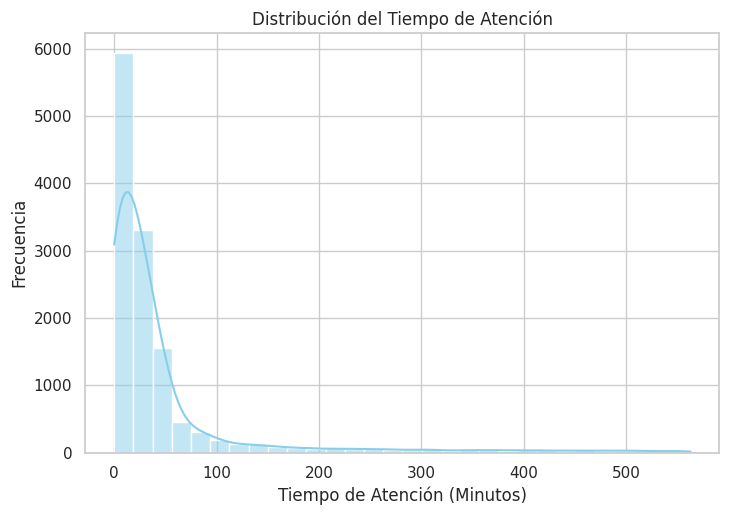

In [192]:
#Histograma del Tiempo de Atención después del tratamiento de atipicos de la variable tiempo de atención

# Configurar estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
sns.histplot(df['TiempoAtencion'], bins=30, kde=True, color='skyblue')
plt.title('Distribución del Tiempo de Atención')
plt.xlabel('Tiempo de Atención (Minutos)')
plt.ylabel('Frecuencia')

In [193]:
#análisis para identificar si realmente hay valores atípicos en la columna de TiempoAtencion usando el método del rango intercuartílico (IQR)
Q1 = df['TiempoAtencion'].quantile(0.25)  # Primer cuartil (25%)
Q3 = df['TiempoAtencion'].quantile(0.75)  # Tercer cuartil (75%)
IQR = Q3 - Q1                      # Rango intercuartílico

#Establece los límites para definir valores atípicos Límites para outliers (1.5*IQR es el estándar)
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtra los valores atípicos (fuera del rango)
outliers = df[(df['TiempoAtencion'] < limite_inferior) | (df['TiempoAtencion'] > limite_superior)]

# Muestra los valores atípicos encontrados
print("Valores atípicos (IQR):")
print(outliers["TiempoAtencion"])

Valores atípicos (IQR):
37       225.0
52       196.0
60       501.0
72       209.0
103      199.0
         ...  
14429    239.0
14434    250.0
14435    194.0
14455    518.0
14501    132.0
Name: TiempoAtencion, Length: 1354, dtype: float64


In [194]:
#obtener el promedio de atención sin tener encuenta los outliers para mejor asignación
promedioatencion = df[~df.index.isin(outliers.index)]['TiempoAtencion'].mean()

# Generar valores aleatorios sólo para los registros outliers
# Obtener los índices de los outliers
indices_outliers = df.index.isin(outliers.index)

# Contar cuántos outliers hay
num_outliers = indices_outliers.sum()

# Asignar valores aleatorios SOLO a los outliers usando loc
df.loc[indices_outliers, 'TiempoAtencion'] = np.random.randint(1, promedioatencion, size=num_outliers)

# Calcular el nuevo promedio
nuevo_promedio = df['TiempoAtencion'].mean()
print(f"Nuevo promedio de TiempoAtencion: {nuevo_promedio:.2f}")

Nuevo promedio de TiempoAtencion: 20.98


Text(0, 0.5, 'Frecuencia')

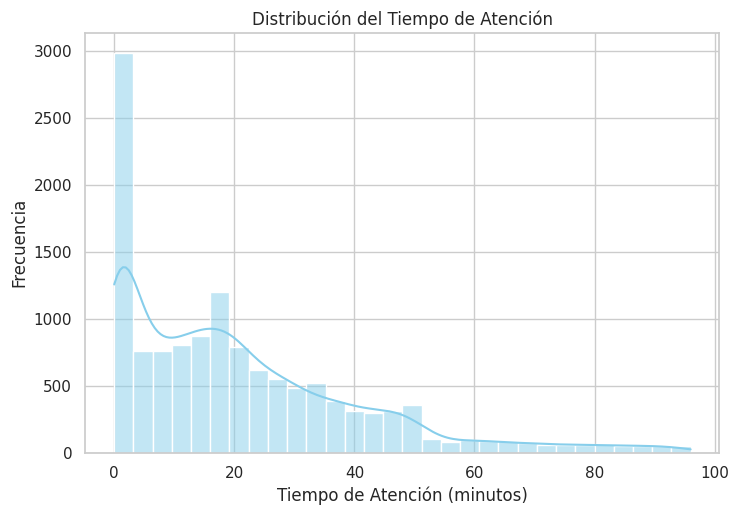

In [195]:
# Histograma del Tiempo de Atención

# Configurar estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
sns.histplot(df['TiempoAtencion'], bins=30, kde=True, color='skyblue')
plt.title('Distribución del Tiempo de Atención')
plt.xlabel('Tiempo de Atención (minutos)')
plt.ylabel('Frecuencia')

## **7. Transformaciones aplicadas (normalización, estandarización, creación de variables derivadas, etc.)**

**Tratamiento de datos Null**
1. Se calcula el valor maximo de tiempo de atención, y luego todos los datos null del campo tiempo de atención se llena con un aleatoria entre 0 y el maximo calculado de tiempo de atención
2. Al campo fechallegada que estan en null se completan con la información de la fecha de la incidencia mas el tiempo de atención calculado previamente
3. El año de añoatencion, mesatencion, diatencion, horaatencion y diasemana se completan sacando la información de la fechallegada previamente calculada

In [196]:
#Tratamiento de datos null
maximo = df['TiempoAtencion'].max()

df_nulos = df[df['TiempoAtencion'].isna()]
# Obtener los índices de los null
indices_null = df.index.isin(df_nulos.index)

# Contar cuántos valores nulos hay
total_nulos = indices_null.sum()

# Asignar valores aleatorios solo a los valores null de la fecha tiempo de atención
df.loc[indices_null, 'TiempoAtencion'] = np.random.randint(0, maximo, size=total_nulos)

#acualizar la fecha de llegada teniendo encuenta el valor calculado aleatoriamente de tiempo de atención
df.loc[indices_null, 'fechallegada'] = df.loc[indices_null, 'fecha'] + pd.to_timedelta(df.loc[indices_null, 'TiempoAtencion'], unit='minutes')
df.loc[indices_null, 'annoatencion'] = df.loc[indices_null, 'fechallegada'].dt.year
df.loc[indices_null, 'mesatencion'] = df.loc[indices_null, 'fechallegada'].dt.month
df.loc[indices_null, 'diaatencion'] = df.loc[indices_null, 'fechallegada'].dt.day
df.loc[indices_null, 'Horaantencion'] = df.loc[indices_null, 'fechallegada'].dt.hour

dias_espanol = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}
df.loc[indices_null, 'diasemana'] = df.loc[indices_null, 'fechallegada'].dt.day_name().map(dias_espanol)

# Calcular el nuevo promedio
nuevo_promedio = df['TiempoAtencion'].mean()
print(f"Nuevo promedio de TiempoAtencion: {nuevo_promedio:.2f}")

df.loc[indices_null, ['Horaantencion', 'diasemana', 'diaatencion', 'mesatencion', 'annoatencion', 'fecha','TiempoAtencion' ,'fechallegada']]

df.to_excel('DataSetFinalTratado.xlsx', index=False)

Nuevo promedio de TiempoAtencion: 23.84
